<a href="https://colab.research.google.com/github/PasechnikDarya/RAAI-NLP-Project/blob/main/topic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [137]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [140]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [141]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

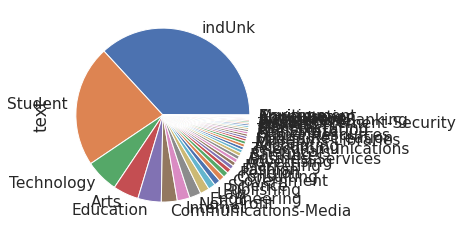

In [142]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

In [143]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)].reset_index(drop=True)

In [144]:
frequencies = data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].values / data.shape[0]
frequencies

array([0.55324969, 0.15117909, 0.11664749, 0.10652455, 0.07239917])

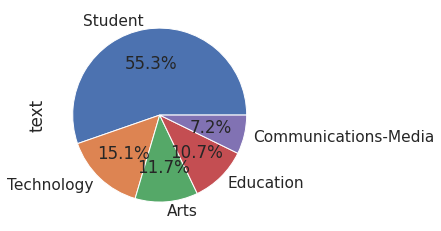

In [145]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [146]:
# for balanced data

# one_class_size = data[data['topic'] == classes[-1]].shape[0]

# prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

# old_data = data
# data = prepr_data.reset_index(drop=True)

In [147]:
CUT = data.shape[0] #100000

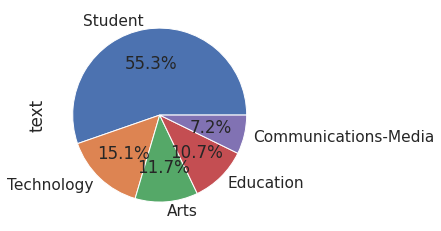

In [148]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [149]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [150]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [151]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [152]:
 class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [153]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [154]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

In [156]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [21]:
# import gensim.downloader as api
# glove_model = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [157]:
from transformers import BertModel

In [158]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [159]:
bert_embeddings = list(bert.children())[0]
bert_word_embeddings = list(bert_embeddings.children())[0]
bert_embeddings = bert_word_embeddings.weight.data.numpy()

In [160]:
bert_embeddings.shape

(30522, 768)

In [22]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [163]:
len(train_dataset.tokenised)

222544

In [165]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

NameError: ignored

In [166]:
train_dataset.cut_to_fixed_size(256)
test_dataset.cut_to_fixed_size(256)

In [167]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [168]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [169]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x)
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [170]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [171]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def measure_quality(y_test, y_pred, average='weighted'):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\t {average}')
    print("accuracy: {:.2f}".format(accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=average)
    print("precision: {:.2f}".format(precision))
    print("recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f_score))
    print()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [172]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    history = {
        'train_loss':[],
        'val_loss':[],
    }

    unfreeze_flg = False
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        
        train_loss = 0

        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:

            if not unfreeze_flg and num_iter > num_freeze_iter:
                freeze_embeddings(model, True)
                unfreeze_flg = True
                
            optimizer.zero_grad()

            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)

            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss

            if num_iter % 1000 == 0:
                print('train loss: ', loss.item())
                print('train: ', (prediction.argmax(-1) == labels).float().sum().item())

            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        
        history['train_loss'].append(train_loss / num_iter)

        valid_loss = 0
        val_labels = None
        val_predictions = None
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
            
                valid_loss += criterion(prediction, labels)
                
                if val_labels is None:
                    val_labels = labels
                else:
                    val_labels = torch.hstack([val_labels, labels])
                
                if val_predictions is None:
                    val_predictions = prediction.argmax(-1)
                else:
                    val_predictions = torch.hstack([val_predictions, prediction.argmax(-1)])

                num_objs += len(labels)
                num_iter += 1

            print('valid: ', (prediction.argmax(-1) == labels).float().sum().item())

            val_labels = val_labels.cpu().numpy()
            val_predictions = val_predictions.cpu().numpy()

        history['val_loss'].append(valid_loss / num_iter)

        measure_quality(val_labels, val_predictions, 'weighted')
        measure_quality(val_labels, val_predictions, 'macro')
        measure_quality(val_labels, val_predictions, 'micro')

        print(f"\n\tValid Loss: {valid_loss / num_iter}\n\t")

    return history

In [178]:
import torch
del model
torch.cuda.empty_cache()
import gc
gc.collect()

278774

In [174]:
idx2label

{0: 'Student',
 1: 'Education',
 2: 'Communications-Media',
 3: 'Arts',
 4: 'Technology'}

In [209]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

model = LSTMModel(len(label2idx), embed_size=bert_embeddings.shape[1], vocab_size=bert_embeddings.shape[0]).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(1 / frequencies).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
max_grad_norm = 1.0

In [211]:
with torch.no_grad():
    model.embedding.weight = torch.nn.Parameter(torch.Tensor(bert_embeddings))

In [179]:
# with torch.no_grad():
#     for word, idx in glove_vocab.vocab.items():
#         if word in glove_model:
#             model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

NameError: ignored

In [41]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [42]:
history = training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

train loss:  1.6078824996948242
train:  3.0
train loss:  1.516856074333191
train:  11.0
train loss:  1.3354119062423706
train:  12.0
train loss:  1.0460491180419922
train:  16.0
train loss:  1.1912237405776978
train:  16.0
train loss:  1.1715792417526245
train:  18.0
train loss:  1.0248969793319702
train:  15.0
train loss:  1.1505237817764282
train:  11.0
valid:  0.0
	 weighted
accuracy: 0.28
precision: 0.72
recall: 0.28
F1-score: 0.26

	 macro
accuracy: 0.28
precision: 0.62
recall: 0.26
F1-score: 0.17

	 micro
accuracy: 0.28
precision: 0.28
recall: 0.28
F1-score: 0.28


	Valid Loss: 1.46524977684021
	


train loss:  1.9540356397628784
train:  6.0
train loss:  1.0917186737060547
train:  17.0
train loss:  0.779193103313446
train:  21.0
train loss:  0.5547426342964172
train:  22.0
train loss:  0.9888008236885071
train:  18.0
train loss:  1.0168039798736572
train:  20.0
train loss:  0.8279063701629639
train:  17.0
train loss:  0.951714813709259
train:  12.0
valid:  0.0
	 weighted
accuracy: 0.36
precision: 0.64
recall: 0.36
F1-score: 0.37

	 macro
accuracy: 0.36
precision: 0.47
recall: 0.33
F1-score: 0.27

	 micro
accuracy: 0.36
precision: 0.36
recall: 0.36
F1-score: 0.36


	Valid Loss: 1.5107229948043823
	


train loss:  1.3405375480651855
train:  13.0
train loss:  0.785901665687561
train:  21.0
train loss:  0.4479997754096985
train:  25.0
train loss:  0.3322241008281708
train:  25.0
train loss:  0.5924128293991089
train:  22.0
train loss:  0.7352234125137329
train:  20.0
train loss:  0.38807183504104614
train:  24.0
train loss:  0.8933077454566956
train:  16.0
valid:  0.0
	 weighted
accuracy: 0.34
precision: 0.58
recall: 0.34
F1-score: 0.35

	 macro
accuracy: 0.34
precision: 0.40
recall: 0.33
F1-score: 0.28

	 micro
accuracy: 0.34
precision: 0.34
recall: 0.34
F1-score: 0.34


	Valid Loss: 1.7220463752746582
	


train loss:  0.8246681690216064
train:  16.0
train loss:  0.4822913408279419
train:  24.0


KeyboardInterrupt: ignored

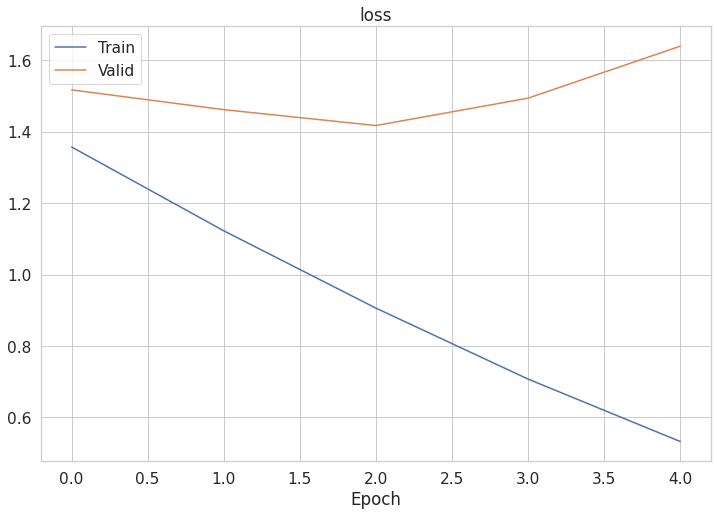

In [117]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

Осталось:
1.   Разумные метрики вроде f1
2.   Сделать, чтобы училось, сейчас не учится
3.   С 0/1/2 полносвязными слоями, fastext и bert embendings



In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])

# BERT

In [14]:
!pip install transformers

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [16]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [121]:
blade = 500

In [122]:
text_data = data['text'][:blade]

In [123]:
topics = data['topic'][:blade]

In [124]:
labels = []
for topic in topics:
    labels.append(label2idx[topic])

In [125]:
len(labels)

250

In [126]:
max_len = 500
for text in tqdm(text_data.index):
    if len(text_data[text]) > max_len:
        text_data[text] = text_data[text][:max_len]

### Tokenization

In [127]:
tokenized = text_data[:blade].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [128]:
tokenized

0      [101, 18558, 2038, 2042, 2179, 1006, 1009, 101...
1      [101, 2122, 2024, 1996, 2136, 2372, 1024, 3881...
2      [101, 1999, 21770, 26159, 2099, 3158, 22762, 2...
3      [101, 5604, 999, 999, 999, 5604, 999, 999, 999...
4      [101, 8299, 1024, 1013, 1013, 7479, 1012, 2039...
                             ...                        
245    [101, 2061, 1996, 3976, 2005, 1996, 2166, 1997...
246    [101, 2253, 2197, 2305, 2000, 1996, 7090, 6765...
247    [101, 2242, 8572, 2015, 2033, 2055, 1996, 2403...
248    [101, 4033, 1005, 1056, 6866, 2505, 1999, 1037...
249    [101, 2619, 3531, 4863, 2000, 2033, 2129, 2619...
Name: text, Length: 250, dtype: object

### Padding

In [129]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

### Masking

In [130]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(250, 178)

### Model

In [131]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [132]:
features = last_hidden_states[0][:,0,:].numpy()
labels = labels[:blade]

In [133]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [134]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
lr_clf.score(test_features, test_labels)

0.6984126984126984

In [136]:
# равномерно 100 samples - 0.6, 0.76, 0,68
# равномерно250 samples - 0.6984